In [57]:
import pandas as pd
import dill as pickle
from ugvc.reports.report_utils import ReportUtils
from ugvc.reports.report_data_loader import ReportDataLoader
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [ ]:
run_id = "NA"
pipeline_version = "NA"
statistics_file = "comp.pkl"
reference_version = "hg38"
truth_sample_name = "NA"
h5outfile = "var_report.h5"    


In [ ]:
parameters = {
    'statistics_file': statistics_file,
    'run_id': run_id,
    'pipeline_version': str(pipeline_version),
    'truth_sample_name': truth_sample_name,
    'h5outfile': h5outfile,
}

parameters = {name: parameters[name] for name in parameters if parameters[name] is not None}
param_names = list(parameters)

report_utils = ReportUtils(1, h5outfile)

display(Markdown(f"# SV/CNV Calling report {pipeline_version} (INTERNAL usage)"))


# SV/CNV Calling report NA (INTERNAL usage)

## 1. Input Parameters <a class="anchor" id="input_parameters"></a>

In [60]:
parameters['statistics_file'] = "/data/Runs/VariantCalling/work/250507/test.stats.pkl"

In [73]:
# load data
data_loader = ReportDataLoader(concordance_file=parameters['statistics_file'],
                               reference_version=parameters['reference_version'],
                               exome_column_name = "exome.twist"
)
data_no_gt, data_gt = data_loader.load_sv_concordance_df()
has_concordance_data = len(data_gt)>0

In [74]:
parameters_df = pd.DataFrame.from_dict(parameters, orient='index', columns=['value']).reindex(param_names)
parameters_df.to_hdf(h5outfile, key="parameters")
display(parameters_df)

,value
statistics_file,/data/Runs/VariantCalling/work/250507/test.stats.pkl
run_id,NA
pipeline_version,NA
verbosity,3
reference_version,hg38
truth_sample_name,NA
h5outfile,var_report.h5


In [75]:
anchor = report_utils.get_anchor("top")
display(Markdown(f"## Table of Contents {anchor}"))
tc = "* [Input Parameters](#input_parameters)\n"
tc += "* [General statistics](#general_statistics)\n"
if data_gt is not None:
    tc += "* [Accuracy](#gen_acc_all_data)\n"

display(Markdown(tc))

## Table of Contents <a class ='anchor' id='top'> </a>

* [Input Parameters](#input_parameters)
* [General statistics](#general_statistics)
* [Accuracy](#gen_acc_all_data)


## General statistics  <a class='anchor' id='all_data'></a>

The tables below summarize class and length distributions of called SVs


### SV type distribution

In [76]:
pd.options.display.float_format = '{:,.2%}'.format
data_no_gt['type_counts'].name = 'SV type'
data_no_gt['type_counts'] = pd.DataFrame(data_no_gt['type_counts']).T

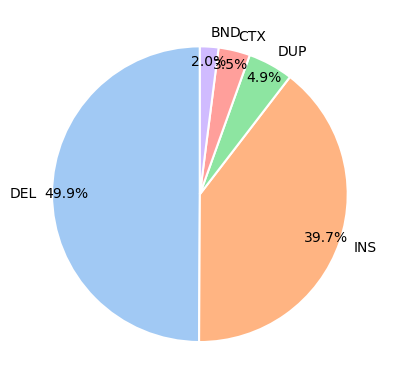

In [77]:
# Pie chart of data_no_gt['type_counts']
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data_no_gt['type_counts'].values[0],
                                   labels=data_no_gt['type_counts'].columns,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   colors=sns.color_palette("pastel"),
                                    pctdistance=0.9,         # keep percentages inside
                                    labeldistance=1.1,        # move labels outside

                                   textprops=dict(color="b"))
for text in texts + autotexts:
    text.set_color("black")
    text.set_fontsize(10)

### SV length distribution

In [78]:
data_no_gt['length_counts'].name = 'SV Length'
data_no_gt['length_counts'] = pd.DataFrame(data_no_gt['length_counts']).T
data_no_gt['length_counts']

,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
SV Length,11016,2943,3114,316,580,130,82,17,53


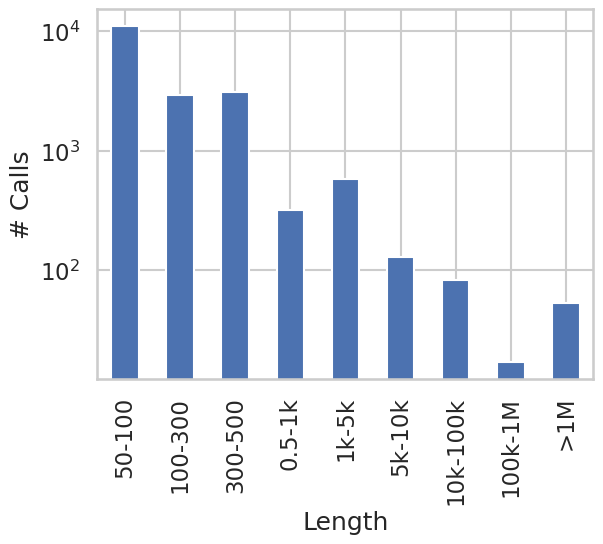

In [79]:
data_no_gt['length_counts'].T.plot.bar(legend=False)
plt.xlabel("Length")
plt.ylabel('# Calls')
# set y axis log scale
plt.yscale('log')


### Length and type distribution

In [80]:
data_no_gt['length_by_type_counts']

binned_svlens,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
svtype,,,,,,,,,
BND,42,55,36,58,110,12,22,8,40
DEL,6365,1167,1099,210,431,110,48,5,1
DUP,578,187,54,41,39,8,12,4,12
INS,4031,1534,1925,7,0,0,0,0,0


In [81]:
data_no_gt['length_by_type_counts'] = data_no_gt['length_by_type_counts'].T
data_no_gt['length_by_type_counts']

svtype,BND,DEL,DUP,INS
binned_svlens,,,,
50-100,42,6365,578,4031
100-300,55,1167,187,1534
300-500,36,1099,54,1925
0.5-1k,58,210,41,7
1k-5k,110,431,39,0
5k-10k,12,110,8,0
10k-100k,22,48,12,0
100k-1M,8,5,4,0
>1M,40,1,12,0


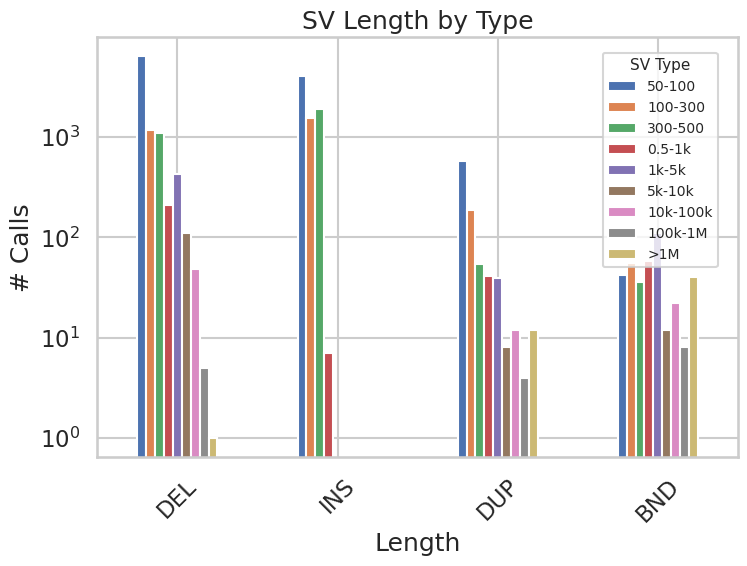

In [84]:
# Make sure the SV types are in the desired order
desired_order = ['DEL', 'INS', 'DUP', 'BND']
df = data_no_gt['length_by_type_counts']
df = df.set_index('svtype') if 'svtype' in df.columns else df
df = df[desired_order].dropna(how='all')

# Plot with legend inside and correct order
ax = df.T.plot(kind='bar', stacked=False, figsize=(8, 6))
plt.xlabel("Length")
plt.ylabel('# Calls')
plt.title('SV Length by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(
    title='SV Type',
    loc='upper right',   # inside the plot
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10,
    title_fontsize=11
)
plt.yscale('log')
plt.show()


In [ ]:
if has_concordance_data:
    anchor = report_utils.get_anchor('concordance_eval')
    display(Markdown(f"## 2 Concordance evaluation {anchor}"))


In [93]:
if has_concordance_data:
    display(Markdown(f"### 2.1 Overall concordance"))
    concordance_df = data_gt['concordance'].copy()


### 2.1 Overall concordance

In [118]:
if has_concordance_data:
    display(Markdown("Recall and precision with comparison to ground truth. Note that sometimes the categories of the variants in ground truth are different than from the calls"
                     "In the evaluation - we do not compare the variant type in the callset to that of the truth set."))
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`==""').droplevel(1,axis=0)
    values_df = values_df[['TP_base', 'TP_calls', 'FP', 'FN','Recall','Precision','F1']]
    roc_df    = concordance_df.query('`SV length`==""').droplevel(1,axis=0)[['precision roc', 'recall roc','thresholds']]
    # show pandas representation for TP_base, TP_calls, FP and FN as integers
    values_df[['TP_base', 'TP_calls', 'FP', 'FN']] = values_df[['TP_base', 'TP_calls', 'FP', 'FN']].astype(int)
    values_df = values_df.loc[values_df['TP_base'] > 0] # remove cases absent from ground truth
    roc_df = roc_df.loc[values_df.index]
    display(values_df)

Recall and precision with comparison to ground truth. Note that sometimes the categories of the variants in ground truth are different than from the callsIn the evaluation - we do not compare the variant type in the callset to that of the truth set.

,TP_base,TP_calls,FP,FN,Recall,Precision,F1
SV type,,,,,,,
ALL,9341,9341,1958,13192,41.45%,82.67%,55.22%
DEL,4497,4745,367,4662,49.10%,92.82%,64.23%
INS,4844,4011,591,8530,36.22%,87.16%,51.17%


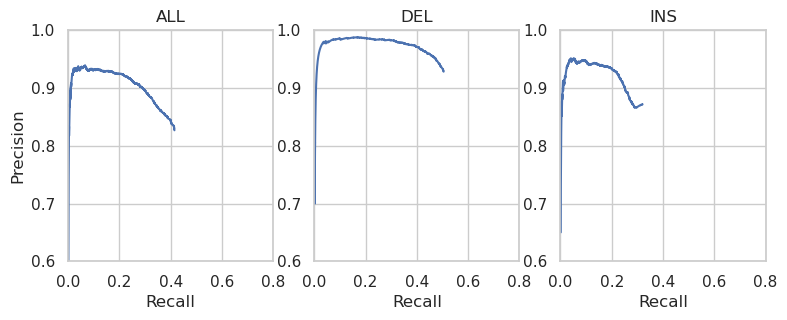

In [116]:
if has_concordance_data:
    fig,ax = plt.subplots(1,roc_df.shape[0],figsize=(roc_df.shape[0]*3,3))
    for i,v in enumerate(roc_df.iterrows()):
        plt.subplot(1,roc_df.shape[0],i+1)
        plt.plot(v[1]['recall roc'],v[1]['precision roc'])
        plt.title(v[0])
        plt.xlabel('Recall')
        plt.xlim(0,0.8)
        plt.ylim(0.6,1)
    ax[0].set_ylabel("Precision")


In [124]:
if has_concordance_data:
    display(Markdown(f"### 2.2 Recall per variant length and type"))
    concordance_df = data_gt['concordance'].copy()
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`!=""')
    values_df = values_df[['TP_base', 'TP_calls', 'FN','Recall']]
    values_df[['TP_base','TP_calls','FN']] = values_df[['TP_base','TP_calls','FN']].astype(int)
    display(values_df)


### 2.2 Recall per variant length and type

TP_base  TP_calls    FN  Recall
SV type SV length                                 
ALL     50-100        3171      3684  4365  42.08%
        100-300       2124      2124  4416  32.48%
        300-500       2308      2734  1692  57.70%
        0.5-1k         611       232  1193  33.87%
        1k-5k          899       417  1210  42.63%
        5k-10k         183       109   162  53.04%
        10k-100k        45        41   154  22.61%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%
DEL     50-100        1751      2051  1758  49.90%
        100-300        955       919  1555  38.05%
        300-500       1070      1049   559  65.68%
        0.5-1k         195       197   348  35.91%
        1k-5k          391       391   334  53.93%
        5k-10k         104       105    48  68.42%
        10k-100k        31        33    60  34.07%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%
INS     50-100        1420      1309  2607  35.26%
        100-300       1169      1057  2861  29.01%
        300-500       1238      1640  1133  52.21%
        0.5-1k         416         5   845  32.99%
        1k-5k          508         0   876  36.71%
        5k-10k          79         0   114  40.93%
        10k-100k        14         0    94  12.96%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%

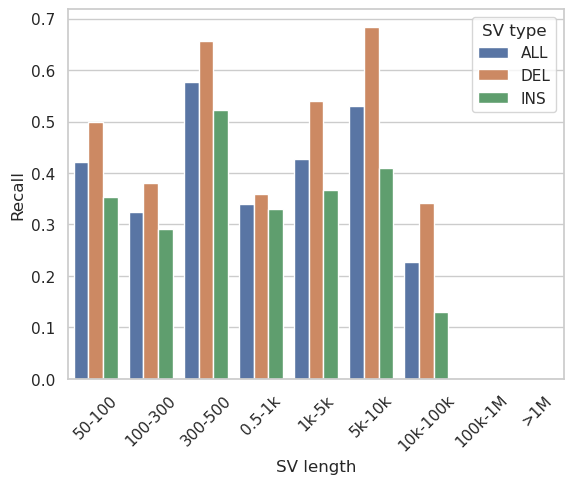

In [129]:
## generate a bar chart of values_df using SV length as x axis and recall as y axis 
sns.barplot(data=values_df.reset_index(), x='SV length', y='Recall', hue='SV type')
plt.xticks(rotation=45);